You should have **analyis.py** in your pyhton working folder (download it here https://github.com/khalednasr/nn-numerosity-zero).

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import analysis


ANALYSING Hz09_casper_h2bcamp7f_7dpf.csv

Number of anova cells for Hz09_casper_h2bcamp7f_7dpf.csv = 435 (78.38%)
(5, 435)
(5, 435)


/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/voxelizer/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Wa

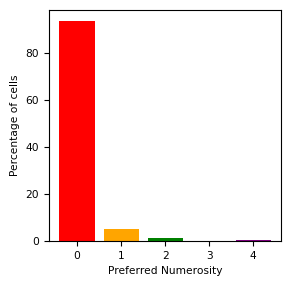

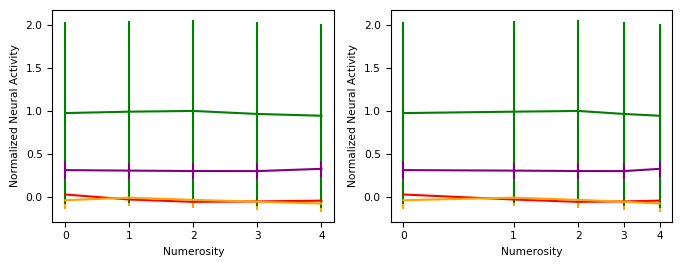

In [65]:
folder = '/Users/mirckuz/Desktop/20230601_Hz09_casper_h2bcamp7f_7dpf_60Z_1hzvol_2P_1v2v3v4v5_processed'
analyze_SV_or_Imaris = 1 # 0 for Super Voxel analysis, 1 for Imaris spot analysis

#set directory depending on type of analysis (SV based or Imaris based)
if analyze_SV_or_Imaris == 0:
    path = folder+'/voxelizer_final_datasets/mask_small'
    os.chdir(path)
elif analyze_SV_or_Imaris == 1:
    path = folder+'/imaris_final_datasets'
    os.chdir(path)
# Configuration parameters
Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange
matplotlib.rcParams.update({'font.size': 7.65}) # plot font size

for file in os.listdir(path):
    if file.startswith('.'):
        continue
    print('\nANALYSING '+file+'\n')
    arr = np.loadtxt(file, delimiter=",")
    C = arr[:,0]#.astype(float).astype(int)
    Q = arr[:,1]#.astype(float).astype(int)
    Hf = arr[:,2:]

    # Find numorosity selective units (anova_cells) using a two-way ANOVA
    pN, pC, pNC = analysis.anova_two_way(Q, C, Hf)
    anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
    R = Hf[:,anova_cells]

    # Calculate and plot ditribution of preferred numerosities
    pref_num = analysis.preferred_numerosity(Q, R)
    hist = [np.sum(pref_num==q) for q in Qrange]
    hist /= np.sum(hist)


    print('Number of anova cells for '+file+' = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))
    plt.figure(figsize=(3,3))
    plt.bar(Qrange, 100*hist, width=0.8, color=colors)
    plt.xlabel('Preferred Numerosity')
    plt.ylabel('Percentage of cells')
    plt.show

    # 1.Calculate average tuning curve of each unit
    tuning_curves = analysis.average_tuning_curves(Q, R)

    ### why not normalizing here????????
    # minim = np.repeat(np.min(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
    # maxim = np.repeat(np.max(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
    # print(tuning_curves.shape)
    # print(minim.shape)
    # tuning_curvesN = tuning_curves-minim/(maxim+minim)

    # 2.Calculate population tuning curves for each preferred numerosity
    tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
    tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                        for q in Qrange])

    # 3.Normalize population tuning curves to the 0-1 range
    tmmin = tuning_mat.min(axis=1)[:,None]
    tmmax = tuning_mat.max(axis=1)[:,None]
    tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
    tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

    # Plot population tuning curves on linear scale
    plt.figure(figsize=(8,2.75))
    plt.subplot(1,2,1)
    for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
        plt.errorbar(Qrange, tc, err, color=colors[i])
        plt.xticks(Qrange)
    plt.xlabel('Numerosity')
    plt.ylabel('Normalized Neural Activity')

    # Plot population tuning curves on log scale
    plt.subplot(1,2,2)
    for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
        plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
        plt.xscale('log', base=2)
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks(ticks=Qrange+1, labels=Qrange)
    plt.xlabel('Numerosity')
    plt.ylabel('Normalized Neural Activity')
    plt.show
